## Extraordinary Hackers and Masters of the Great Web. Gas Analysis

In [1]:
from math import log10
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import HTML, display

from config import PROJECT_ID, GAS_ANALYSIS_DATASET_NAME, INITIAL_TS, SNAPSHOT_TS, \
    GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, GAS_SPEND_BY_CONTRACT_TABLE_NAME
from src.utils import drop_table, create_table, get_df
from src.utils_charts import grade_boundaries_analysis

DROP_TABLES = True
CREATE_TABLES = True

### Distribution Rule. Extraordinary Hackers

<table style="text-align: center">
    <thead>
        <tr>
            <th rowspan=2> Fee spending to created contracts<sup>1</sup>, ETH </th>
            <th colspan=3>Grade</th>
        </tr>
        <tr>
            <th>1</th>
            <th>2</th>
            <th>3</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align: left"> - by contract creators<sup>2</sup> </td>
            <td> > 0 ETH </td>
            <td> > 8 ETH </td>
            <td> > 75 ETH </td>
        </tr>
        <tr>
            <td style="text-align: left"> - by factory creators<sup>3</sup> </td>
            <td> - </td>
            <td> > 0 ETH </td>
            <td> > 10 ETH </td>
        </tr>
    </tbody>
</table>
<i>
<sup>1</sup>  excluding fee from a contract creator address<br>
<sup>2</sup>  excluding contracts created by factories<br>
<sup>3</sup>  excluding factories that only created contracts when called from the creator of that factory
</i>
<br><br>

### Distribution Rule. Masters of the Great Web
Described in the [Masters of the Great Web](masters__erc721_analysis.ipynb) Jupyter notebook

In [2]:
spending_fee_by_contract_creator = [0, 8, 75]
spending_fee_by_contract_creator_by_factory = [0, 0.005, 0.075]
spending_fee_by_factory_creator = [0, 0, 10]

### Create Table with Spending Gas by Contracts

In [3]:
query_1 = f'''
        WITH gas_spend AS (
            SELECT
                from_address,
                to_address,
                sum(cast(receipt_gas_used as numeric) * cast(gas_price as numeric))/1e18 as fee
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
            GROUP BY from_address, to_address
            ORDER BY fee DESC
        ),
        traces_with_contracts_creation AS (
            SELECT
                transaction_hash,
                from_address,
                to_address
            FROM `bigquery-public-data.crypto_ethereum.traces`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}'
              AND trace_type ='create'
              AND status = 1),
        tx_sender_and_hash AS (
            SELECT
                from_address,
                `hash` as transaction_hash
            FROM `bigquery-public-data.crypto_ethereum.transactions`
            WHERE block_timestamp >= '{INITIAL_TS}'
              AND block_timestamp <= '{SNAPSHOT_TS}')
        SELECT
            contract_address,
            factory_address,
            creator_address,
            sum(fee) as fee
        FROM (
            SELECT
                contracts_creation.to_address as contract_address,
                if(contracts_creation.from_address = tx_sender.from_address, null, contracts_creation.from_address)  as factory_address,
                tx_sender.from_address as creator_address,
                gas.fee as fee
            FROM gas_spend as gas
            INNER JOIN traces_with_contracts_creation as contracts_creation 
                ON gas.to_address = contracts_creation.to_address
            LEFT JOIN tx_sender_and_hash as tx_sender 
                ON contracts_creation.transaction_hash = tx_sender.transaction_hash 
                   AND gas.from_address != tx_sender.from_address)
        GROUP BY contract_address, factory_address, creator_address
'''

if DROP_TABLES:
    drop_table(GAS_SPEND_BY_CONTRACT_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)
if CREATE_TABLES:
    create_table(query_1, GAS_SPEND_BY_CONTRACT_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)

Table gas_analysis:gas_spend_by_contract has been deleted.
Table gas_analysis:gas_spend_by_contract has been created and filled 4456059 rows.


### Create Table with Distribution by Contract and Factory Creators

In [4]:
query_2 = f'''
        WITH fee_by_factory AS (
            SELECT
                factory_address,
                sum(fee) as sum_fee
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
            WHERE factory_address is not null
              AND creator_address is not null
            GROUP BY factory_address
            ),
        factory_creators AS (
            SELECT
                contract_address as factory_address,
                creator_address as factory_creator
            FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
            WHERE contract_address IN (
                SELECT DISTINCT factory_address
                FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
                )
              AND creator_address is not null
            ),
        contract_creators AS (
            SELECT
                address,
                subtype,
                sum(fee) as sum_fee
            FROM (
                SELECT
                    creator_address as address,
                    if(factory_address is null, 'Contract Creator', 'Contract Creator by Factory') as subtype,
                    fee
                FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_SPEND_BY_CONTRACT_TABLE_NAME}`
                WHERE creator_address is not null
                )
            GROUP BY address, subtype)
        SELECT
            'Factory Creator' as subtype,
            factory_creator as address,
            fee_3 as sum_fee,
            CASE
                WHEN fee_3 > {spending_fee_by_factory_creator[2]} THEN 3
                WHEN fee_3 > {spending_fee_by_factory_creator[1]} THEN 2
                WHEN fee_3 > {spending_fee_by_factory_creator[0]} THEN 1
                ELSE null
            END
            AS grade
        FROM (
            SELECT
                factory_creator,
                sum(sum_fee) as fee_3
            FROM fee_by_factory as ff
            LEFT JOIN factory_creators as fc ON ff.factory_address = fc.factory_address
            GROUP BY factory_creator)
        WHERE factory_creator is not null
        UNION ALL
        SELECT
            subtype,
            address,
            sum_fee,
            CASE
                WHEN (subtype = 'Contract Creator' AND sum_fee > {spending_fee_by_contract_creator[2]}) OR
                     (subtype = 'Contract Creator by Factory' AND sum_fee > {spending_fee_by_contract_creator_by_factory[2]}) THEN 3
                WHEN (subtype = 'Contract Creator' AND sum_fee > {spending_fee_by_contract_creator[1]}) OR
                     (subtype = 'Contract Creator by Factory' AND sum_fee > {spending_fee_by_contract_creator_by_factory[1]}) THEN 2
                WHEN (subtype = 'Contract Creator' AND sum_fee > {spending_fee_by_contract_creator[0]}) OR
                     (subtype = 'Contract Creator by Factory' AND sum_fee > {spending_fee_by_contract_creator_by_factory[0]}) THEN 1
                ELSE null
            END
            AS grade
        FROM contract_creators
        ORDER BY sum_fee DESC;
'''

if DROP_TABLES:
    drop_table(GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)
if CREATE_TABLES:
    create_table(query_2, GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME, dataset_name=GAS_ANALYSIS_DATASET_NAME)

Table gas_analysis:gas_analysis_distribution has not been deleted.
404 DELETE https://bigquery.googleapis.com/bigquery/v2/projects/cosmic-keep-223223/datasets/gas_analysis/tables/gas_analysis_distribution?prettyPrint=false: Not found: Table cosmic-keep-223223:gas_analysis.gas_analysis_distribution
Table gas_analysis:gas_analysis_distribution has been created and filled 350202 rows.


### Analysis of Grade Boundaries. Extraordinary Hackers. Fee Spending to Created Contracts by Contract Creators

In [5]:
query_4 = f'''
    SELECT
        ROUND(sum_fee, 2) AS fee_class,
        count(address) as number_of_creators
    FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    WHERE subtype = 'Contract Creator'
      AND sum_fee > 0
    GROUP BY fee_class
    ORDER BY fee_class;
'''
fee_spending_hackers_distribution_df = get_df(query_4)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0 < Fee spending to created contracts <= 8.0,49390,89.2
2,8.0 < Fee spending to created contracts <= 75.0,4322,7.8
3,75.0 < Fee spending to created contracts,1679,3.0


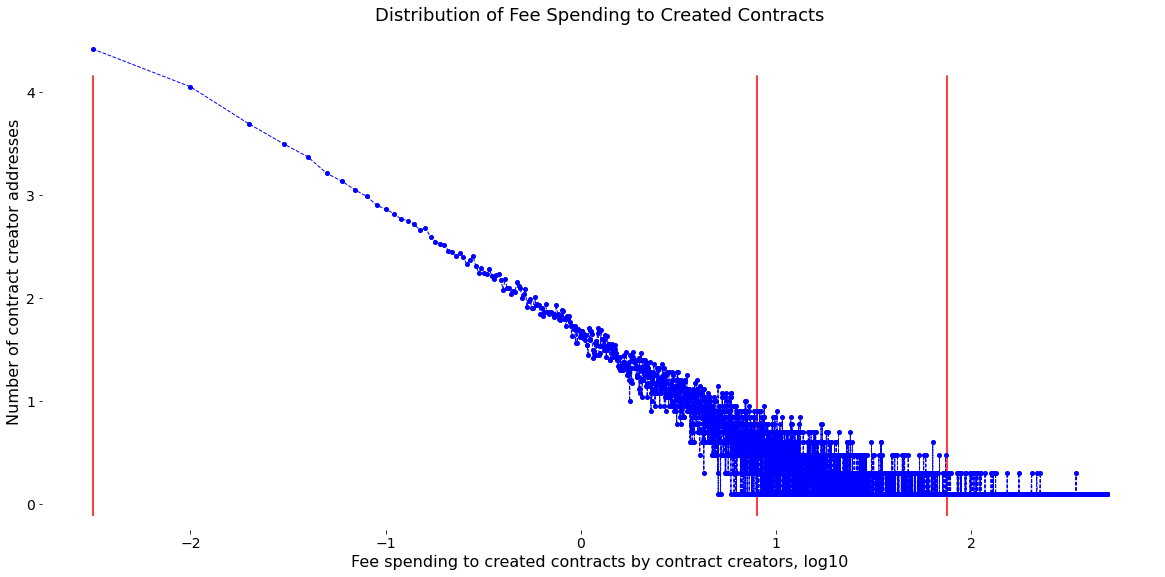

[0, 8.0, 75.0]

In [6]:
grade_boundaries_analysis(
    fee_spending_hackers_distribution_df,
    value_column = 'fee_class',
    address_column='number_of_creators',
    address_chart_label='Number of contract creator addresses',
    value_chart_label = 'Fee spending to created contracts by contract creators, log10',
    value_name = 'Fee spending to created contracts',
    value_transform_func=lambda x: log10(x) if x > 0 else -2.5,
    chart_title = 'Distribution of Fee Spending to Created Contracts',
    max_show_value = 500,
    initial_boundary=0,
    level_line_shift=0)

### Analysis of Grade Boundaries. Masters of the Great Web. Fee Spending to Created Contracts

In [7]:
query_5 = f'''
    SELECT
        ROUND(sum_fee, 2)+0.005 AS fee_class,
        count(address) as number_of_creators
    FROM `{PROJECT_ID}.{GAS_ANALYSIS_DATASET_NAME}.{GAS_ANALYSIS_DISTRIBUTION_TABLE_NAME}`
    WHERE subtype = 'Contract Creator by Factory'
      AND grade IN (1,2,3)
      AND sum_fee > 0
    GROUP BY fee_class
    ORDER BY fee_class;
'''
fee_spending_masters_distribution_df = get_df(query_5)

Suggestion of Rules: 



Grade,Rule,Addresses,Percentage of Addresses
1,0 < Fee spending to created contracts <= 0.005,237758,89.2
2,0.005 < Fee spending to created contracts <= 0...,20596,7.7
3,0.075 < Fee spending to created contracts,8292,3.1


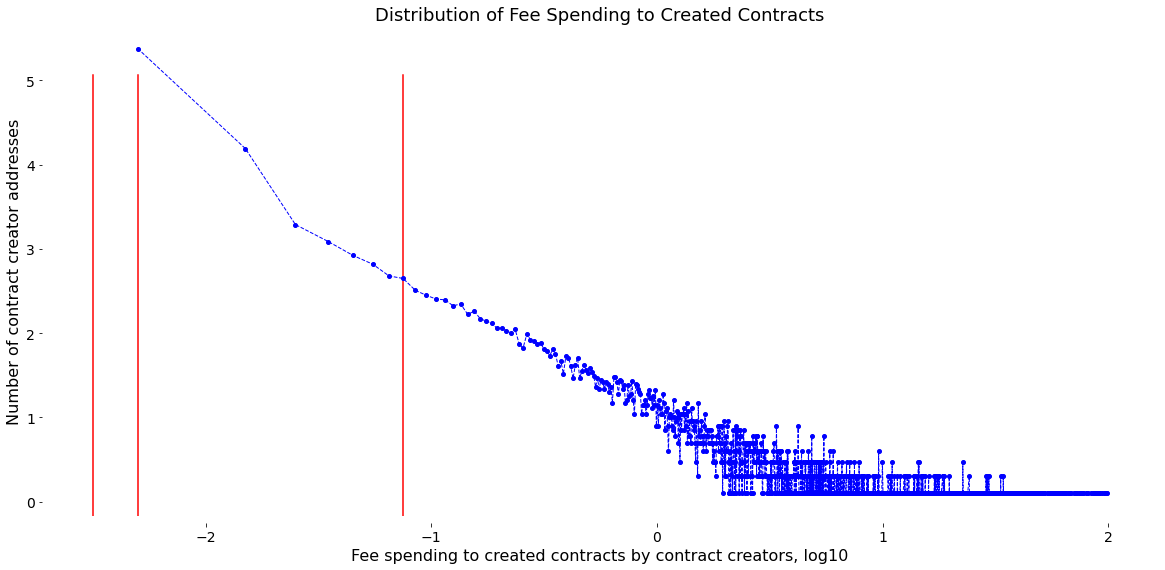

[0, 0.005, 0.075]

In [8]:
grade_boundaries_analysis(
    fee_spending_masters_distribution_df,
    value_column='fee_class',
    address_column='number_of_creators',
    address_chart_label='Number of contract creator addresses',
    value_chart_label='Fee spending to created contracts by contract creators, log10',
    value_name='Fee spending to created contracts',
    value_transform_func=lambda x: log10(x) if x > 0 else -2.5,
    chart_title='Distribution of Fee Spending to Created Contracts',
    max_show_value=100,
    initial_boundary=0,
    level_line_shift=0,
    boundary_round=3)